In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date_str = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date_str = latest_date_str[0]
latest_date = dt.datetime.strptime(latest_date_str, '%Y-%m-%d')
latest_date

datetime.datetime(2017, 8, 23, 0, 0)

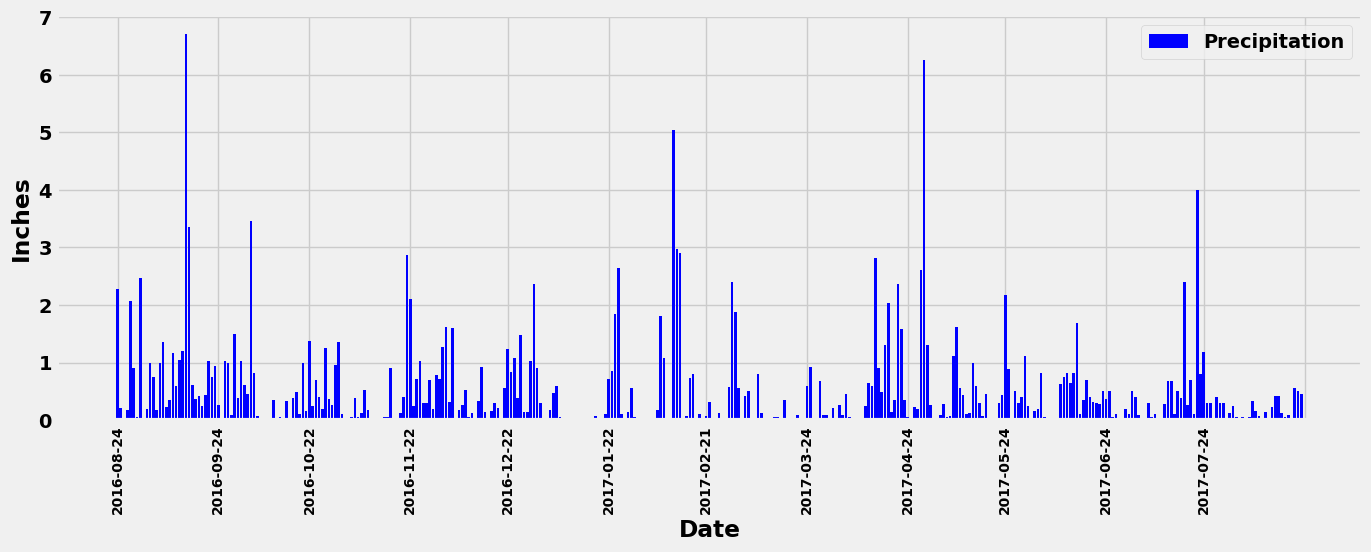

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
latest_date_1 = dt.datetime(latest_date.year - 1, latest_date.month, latest_date.day)

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date <= latest_date).filter(measurement.date >= latest_date_1).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year = pd.DataFrame(last_year)
last_year.columns = ['Date', 'Precipitation']
last_year.set_index('Date')

# Sort the dataframe by date
last_year = last_year.sort_values(by = 'Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize = (15, 5))
plt.bar(last_year['Date'], last_year['Precipitation'], color='b', align="center")
plt.xticks(fontsize = 10, rotation = "vertical")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(['Precipitation'], loc = 1)

ax = plt.subplot()
# set monthly locator
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year[['Precipitation']].describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).count()
stations

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()[0]

#Lowest temp
lowest_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == most_active).first()[0]

#Highest temp
highest_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == most_active).first()[0]

#Average temp
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active).first()[0]

answers = {'Most Active Station': most_active,
           'Lowest Temp': lowest_temp,
           'Highest Temp': highest_temp,
           'Average Temp': round(avg_temp, 1)}
answers

{'Most Active Station': 'USC00519281',
 'Lowest Temp': 54.0,
 'Highest Temp': 85.0,
 'Average Temp': 71.7}

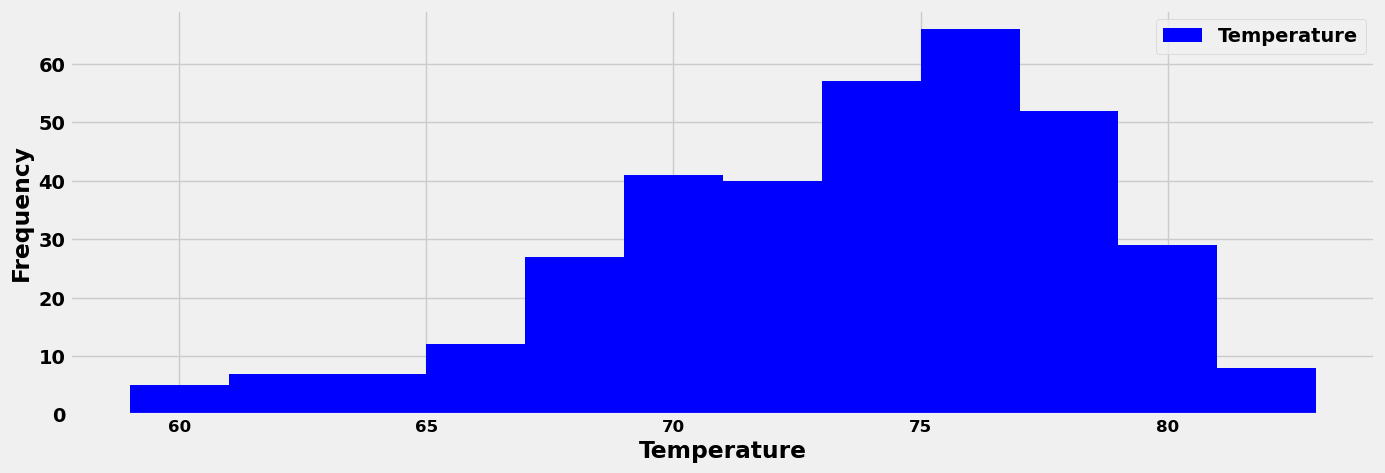

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_2 = session.query(measurement.tobs).\
    filter(measurement.date <= latest_date).filter(measurement.date >= latest_date_1).filter(measurement.station == most_active).all()
last_year_2

#Histogram values
hist = np.histogram(last_year_2, bins = 12)
counts, bins = hist

#Histogram plot
plt.figure(figsize = (15, 5))
plt.stairs(counts, bins, color = 'b', fill=True)
plt.xticks(fontsize = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(['Temperature'], loc = 1)

# Close session

In [18]:
# Close Session
session.close()